# Overview

In this project, I will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens Small Datasets](https://grouplens.org/datasets/movielens/latest/)

## [Recommender system](https://en.wikipedia.org/wiki/Recommender_system)
A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors

Recommender systems typically produce a list of recommendations through collaborative filtering or through content-based filtering

This project will focus on collaborative filtering and use Alternating Least Squares (ALS) algorithm to make movie predictions

## [Alternating Least Squares](https://endymecy.gitbooks.io/spark-ml-source-analysis/content/%E6%8E%A8%E8%8D%90/papers/Large-scale%20Parallel%20Collaborative%20Filtering%20the%20Netflix%20Prize.pdf)
ALS is one of the low rank matrix approximation algorithms for collaborative filtering. ALS decomposes user-item matrix into two low rank matrixes: user matrix and item matrix. In collaborative filtering, users and products are described by a small set of latent factors that can be used to predict missing entries. And ALS algorithm learns these latent factors by matrix factorization

## Data Sets
We use [MovieLens Small Datasets](https://grouplens.org/datasets/movielens/latest/)
This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100004 ratings and 1296 tag applications across 9125 movies. These data were created by 671 users between January 09, 1995 and October 16, 2016. This dataset was generated on October 17, 2016.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`

## Project Content
1. Load Data
2. Spark SQL and OLAP
3. Spark ALS based approach for training model
4. ALS Model Selection and Evaluation
5. Model testing

In [2]:
import os
import time

# spark imports
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [4]:
# path config
data_path = '../data/movie/'

## Load Data

In [5]:
movies = spark.read.load(os.path.join(data_path, 'movies.csv'), format='csv', header=True)
ratings = spark.read.load(os.path.join(data_path, 'ratings.csv'), format='csv', header=True)
links = spark.read.load(os.path.join(data_path, 'links.csv'), format='csv', header=True)
tags = spark.read.load(os.path.join(data_path, 'tags.csv'), format='csv', header=True)

### basic inspection

In [6]:
movies.show(3)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
+-------+--------------------+--------------------+
only showing top 3 rows



In [8]:
ratings.show(3)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
+------+-------+------+----------+
only showing top 3 rows



In [9]:
links.show(3)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
+-------+-------+------+
only showing top 3 rows



In [10]:
tags.show(3)

+------+-------+--------------------+----------+
|userId|movieId|                 tag| timestamp|
+------+-------+--------------------+----------+
|    15|    339|sandra 'boring' b...|1138537770|
|    15|   1955|             dentist|1193435061|
|    15|   7478|            Cambodia|1170560997|
+------+-------+--------------------+----------+
only showing top 3 rows



## Spark SQL and OLAP

Below are the questions I'd like to ask:
1. What are the ratings?
2. What is minimum number of ratings per user and minimum number of ratings per movie?
3. How many movies are rated by only one user?
4. What is the total number of users in the data sets?
5. What is the total number of movies in the data sets?
6. How many movies are rated by users? List movies not rated yet?
7. List all movie genres
8. Find out the number of movies for each category

What are the ratings?

In [6]:
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
['0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0']


What is minimum number of ratings per user and minimum number of ratings per movie?

In [7]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


How many movies are rated by only one user?

In [8]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3063 out of 9066 movies are rated by only one user


What is the total number of users in the data sets?

In [9]:
tmp = ratings.select('userID').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

We have a total of 671 distinct users in the data sets


What is the total number of movies in the data sets?

In [10]:
tmp = movies.select('movieID').distinct().count()
print('We have a total of {} distinct movies in the data sets'.format(tmp))

We have a total of 9125 distinct movies in the data sets


How many movies are rated by users? List movies not rated yet?

In [13]:
tmp1 = movies.select('movieID').distinct().count()
tmp2 = ratings.select('movieID').distinct().count()
print('We have a total of {} distinct movies that are rated by users in ratings table'.format(tmp2))
print('We have {} movies that are not rated yet'.format(tmp1-tmp2))

We have a total of 9066 distinct movies that are rated by users in ratings table
We have 59 movies that are not rated yet


In [36]:
# create a temp SQL table view for easier query
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")
# SQL query (NOTE: WHERE ... NOT IN ... == ... LEFT JOIN ... WHERE ... IS NULL)
print('List movies that are not rated yet: ')
spark.sql(
    "SELECT m.movieId, m.title "
    "FROM movies m LEFT JOIN ratings r ON m.movieID = r.movieID "
    "WHERE r.movieId IS NULL"
).show(20)

List movies that are not rated yet: 
+-------+--------------------+
|movieId|               title|
+-------+--------------------+
|   4712|Wild Child, The (...|
|   4763|Iron Ladies, The ...|
|   5169|Scarlet Street (1...|
|   5289|Body and Soul (1947)|
|   5984|Story of O, The (...|
|   6229|Two-Lane Blacktop...|
|   6515|You Only Live Onc...|
|   6683|         Fire (1996)|
|   6830|  Sudden Fear (1952)|
|   7243|Intolerance: Love...|
|   7335|Pickup on South S...|
|   8236|While the City Sl...|
|   8494|Cincinnati Kid, T...|
|   8766|  Black Angel (1946)|
|   8767|Big Clock, The (1...|
|  25927|Stranger, The (1946)|
|  34517|      Berserk (1967)|
|  39421|After School Spec...|
|  41585|Kiss of Death (1947)|
|  42217|Late Spring (Bans...|
+-------+--------------------+
only showing top 20 rows



List all movie genres

In [53]:
# define a udf for splitting the genres string
splitter = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
# query
print('All distinct genres: ')
movies.select(explode(splitter("genres")).alias("genres")).distinct().show()

All distinct genres: 
+------------------+
|            genres|
+------------------+
|             Crime|
|           Romance|
|          Thriller|
|         Adventure|
|             Drama|
|               War|
|       Documentary|
|           Fantasy|
|           Mystery|
|           Musical|
|         Animation|
|         Film-Noir|
|(no genres listed)|
|              IMAX|
|            Horror|
|           Western|
|            Comedy|
|          Children|
|            Action|
|            Sci-Fi|
+------------------+



Find out the number of movies for each category

In [62]:
print('Counts of movies per genre')
movies.select('movieID', explode(splitter("genres")).alias("genres")) \
    .groupby('genres') \
    .count() \
    .sort(desc('count')) \
    .show()

Counts of movies per genre
+------------------+-----+
|            genres|count|
+------------------+-----+
|             Drama| 4365|
|            Comedy| 3315|
|          Thriller| 1729|
|           Romance| 1545|
|            Action| 1545|
|         Adventure| 1117|
|             Crime| 1100|
|            Horror|  877|
|            Sci-Fi|  792|
|           Fantasy|  654|
|          Children|  583|
|           Mystery|  543|
|       Documentary|  495|
|         Animation|  447|
|           Musical|  394|
|               War|  367|
|           Western|  168|
|              IMAX|  153|
|         Film-Noir|  133|
|(no genres listed)|   18|
+------------------+-----+



## Spark ALS based approach for training model
1. Reload data
2. Split data into train, validation, test
3. ALS model selection and evaluation
4. Model testing

### Reload data
We will use an RDD-based API from pyspark.mllib to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [82]:
# load data
movie_rating = sc.textFile(os.path.join(data_path, 'ratings.csv'))
# preprocess data -- only need ["userId", "movieId", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(1, 31, 2.5), (1, 1029, 3.0), (1, 1061, 3.0)]

### Split data
Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [83]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[373] at RDD at PythonRDD.scala:53

### ALS model selection and evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [93]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [92]:
# hyper-param config
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 1.016671755657645
6 latent factors and regularization = 0.1: validation RMSE is 0.942718346907156
6 latent factors and regularization = 0.2: validation RMSE is 0.9157710976382633
6 latent factors and regularization = 0.4: validation RMSE is 0.9796623234910976
6 latent factors and regularization = 0.8: validation RMSE is 1.1996977342629649
8 latent factors and regularization = 0.05: validation RMSE is 1.0241672561451265
8 latent factors and regularization = 0.1: validation RMSE is 0.947591485112185
8 latent factors and regularization = 0.2: validation RMSE is 0.9164495145304815
8 latent factors and regularization = 0.4: validation RMSE is 0.9805069447939836
8 latent factors and regularization = 0.8: validation RMSE is 1.1996899068814417
10 latent factors and regularization = 0.05: validation RMSE is 1.0372193970395194
10 latent factors and regularization = 0.1: validation RMSE is 0.9420720159977722
10 latent factors and regu

### ALS model learning curve
As we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

In [102]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

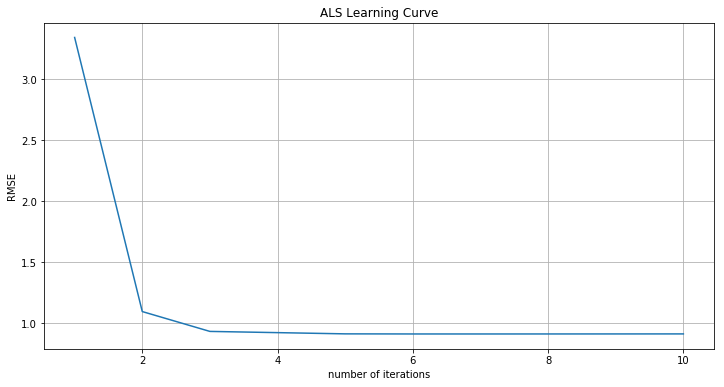

In [104]:
# create an array of num_iters
iter_array = [1, 2, 3, 5, 6, 7, 8, 9, 10]
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.2, 10)

After 3 iterations, alternating gradient descend starts to converge at an error around 0.9

### Model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [113]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.9206
